In [1]:
import numpy as np
import cvxpy as cp

import scipy

from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Learned Iterative Soft Thresholding Algorithm (LISTA)

In [15]:
# Dimensions for the signal, its sparsity and its observation

n_ = 500
m_ = 250
p_ = 0.02

# Sensing matrix

A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
A_ /= torch.linalg.norm(A_, dim = 0)

# Building a training set and a test set 
train_set = SyntheticSignals(
    A = A_,
    n = n_,        
    m = m_,
    p = p_,
    SNR = None,
    size = 4000
    ).set_loader()

test_set = SyntheticSignals(
    A = A_,
    n = n_,        
    m = m_,
    p = p_,
    SNR = None,
    size = 1000
    ).set_loader()

In [17]:
np.linalg.matrix_rank(A_.numpy())

250

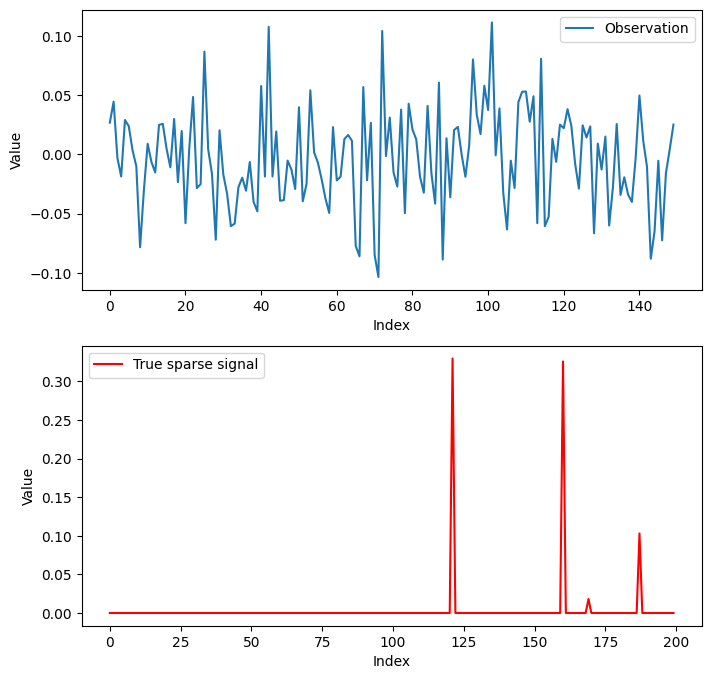

In [4]:
x_exm, s_exm =test_set.dataset.__getitem__(20)
plt.figure(figsize=(8, 8)) 
plt.subplot(2, 1, 1) 
plt.plot(x_exm, label = 'Observation' ) 
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.subplot (2, 1, 2) 
plt.plot(s_exm, label = 'True sparse signal', color='r')  
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend()
plt.show()

### Comparing ISTA and LISTA

In [ ]:
model = LISTA_Net(torch.clone(A_), 0.4, 5)
loss = train(model, train_set, test_set, num_epochs=100, verbose = False)

In [17]:
M = 1
LAYERS = 5

ISTA_LOSS = np.zeros((M, 100))
FISTA_LOSS = np.zeros((M, 100))
LISTA_LOSS = np.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Dimensions for the signal, its sparsity and its observation

    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, 100, A_, rho = 0.4)
    FISTA_LOSS[m,:] = FISTA_BATCH(test_set, 100, A_, rho = 0.4)
    LISTA_LOSS[m,:] = model.compute_nmse_inference(test_set)

100%|██████████| 1/1 [00:19<00:00, 19.67s/it]


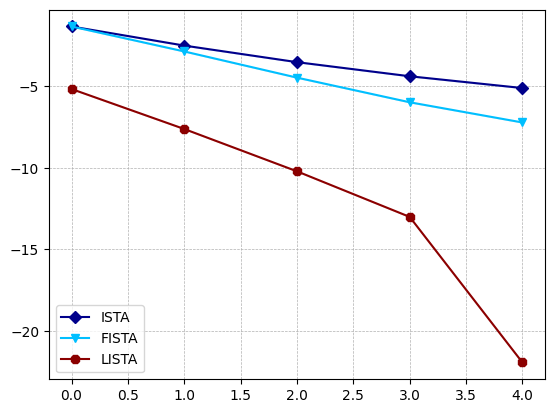

In [18]:
plt.plot(np.mean(ISTA_LOSS, axis = 0)[0:LAYERS], label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0)[0:LAYERS] - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0)[0:LAYERS], 
                np.mean(ISTA_LOSS, axis = 0)[0:LAYERS] + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0)[0:LAYERS], 
                color='cornflowerblue', 
                alpha=0.2)

plt.plot(np.mean(FISTA_LOSS, axis = 0)[0:LAYERS], label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(LAYERS), 
                np.mean(FISTA_LOSS, axis = 0)[0:LAYERS] - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0)[0:LAYERS], 
                np.mean(FISTA_LOSS, axis = 0)[0:LAYERS] + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0)[0:LAYERS], 
                color='skyblue', 
                alpha=0.2)

plt.plot(np.mean(LISTA_LOSS, axis = 0), label='LISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(LISTA_LOSS, axis = 0) - (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    np.mean(LISTA_LOSS, axis = 0) + (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    color='lightcoral', 
                    alpha=0.2)

plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

# ALISTA - Linear transformation is computed analitically

### LISTA vs ALISTA vs TILISTA - Fight!

### Noiseless case

In [ ]:
M = 50
LAYERS = 20
BETA_INIT = 0.4
EPOCHS = 50
SNR = None

LISTA_LOSS = np.zeros((M, LAYERS))
ALISTA_LOSS = np.zeros((M, LAYERS))
TiLISTA_LOSS = np.zeros((M, LAYERS))
L2O_ISTA_LOSS = np.zeros((M, LAYERS))
ISTA_LOSS = np.zeros((M, LAYERS))
FISTA_LOSS = np.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Dimensions for the signal, its sparsity and its observation

    n_ = 500
    m_ = 250
    p_ = 0.1

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 4000
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 1000
        ).set_loader()
    
    model1 = LISTA_Net(torch.clone(A_), BETA_INIT, LAYERS)
    train(model1, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model2 = ALISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model2, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model3 = TiLISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model3, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model4 = L2O_ISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model4, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    LISTA_LOSS[m,:] = model1.compute_nmse_inference(test_set)
    ALISTA_LOSS[m,:] = model2.compute_nmse_inference(test_set)
    TiLISTA_LOSS[m,:] = model3.compute_nmse_inference(test_set)
    L2O_ISTA_LOSS[m,:] = model4.compute_nmse_inference(test_set)

    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)
    FISTA_LOSS[m,:] = FISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)

# Sometimes convergence is not reached in training
LISTA_LOSS = LISTA_LOSS[~np.isnan(LISTA_LOSS).any(axis=1)]
ALISTA_LOSS = ALISTA_LOSS[~np.isnan(ALISTA_LOSS).any(axis=1)]
TiLISTA_LOSS = TiLISTA_LOSS[~np.isnan(TiLISTA_LOSS).any(axis=1)]
L2O_ISTA_LOSS = L2O_ISTA_LOSS[~np.isnan(L2O_ISTA_LOSS).any(axis=1)]

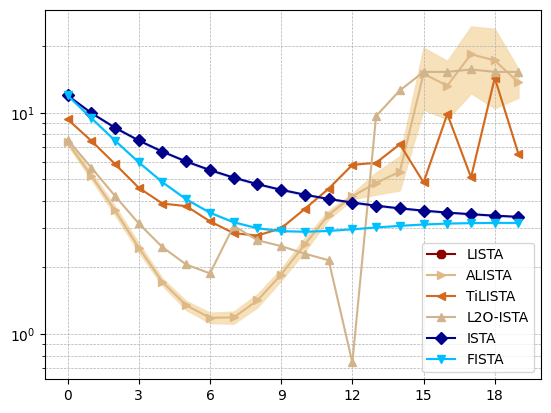

In [79]:
plt.plot(np.mean(LISTA_LOSS, axis = 0), label='LISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(LISTA_LOSS, axis = 0) - (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    np.mean(LISTA_LOSS, axis = 0) + (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    color='darkred', 
                    alpha=0.1)

plt.plot(np.mean(ALISTA_LOSS, axis = 0), label='ALISTA', color='burlywood', marker = '>')
plt.fill_between(range(LAYERS), 
                    np.mean(ALISTA_LOSS, axis = 0) - (2/np.sqrt(ALISTA_LOSS.shape[1])) * np.std(ALISTA_LOSS, axis = 0), 
                    np.mean(ALISTA_LOSS, axis = 0) + (2/np.sqrt(ALISTA_LOSS.shape[1])) * np.std(ALISTA_LOSS, axis = 0), 
                    color='wheat', 
                    alpha=0.9)

plt.plot(np.mean(TiLISTA_LOSS, axis = 0), label='TiLISTA', color='chocolate', marker = '<')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLISTA_LOSS, axis = 0) - (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    np.mean(TiLISTA_LOSS, axis = 0) + (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    color='sandybrown', 
                    alpha=0.2)
plt.plot(np.mean(L2O_ISTA_LOSS, axis = 0), label='L2O-ISTA', color='tan', marker = '^')
plt.fill_between(range(LAYERS), 
                    np.mean(L2O_ISTA_LOSS, axis = 0) - (2/np.sqrt(L2O_ISTA_LOSS.shape[1])) * np.std(L2O_ISTA_LOSS, axis = 0), 
                    np.mean(L2O_ISTA_LOSS, axis = 0) + (2/np.sqrt(L2O_ISTA_LOSS.shape[1])) * np.std(L2O_ISTA_LOSS, axis = 0), 
                    color='moccasin', 
                    alpha=0.2)
plt.plot(np.mean(ISTA_LOSS, axis = 0), label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0) - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                np.mean(ISTA_LOSS, axis = 0) + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                color='cornflowerblue', 
                alpha=0.2)

plt.plot(np.mean(FISTA_LOSS, axis = 0), label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(LAYERS), 
                np.mean(FISTA_LOSS, axis = 0) - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                np.mean(FISTA_LOSS, axis = 0) + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                color='skyblue', 
                alpha=0.2)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()
plt.yscale('log')

### 30db gain 

In [47]:
M = 50
LAYERS = 20
BETA_INIT = 1
EPOCHS = 50
SNR = 1000

LISTA_LOSS = np.zeros((M, LAYERS))
ALISTA_LOSS = np.zeros((M, LAYERS))
TiLISTA_LOSS = np.zeros((M, LAYERS))
L2O_ISTA_LOSS = np.zeros((M, LAYERS))
ISTA_LOSS = np.zeros((M, LAYERS))
FISTA_LOSS = np.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Dimensions for the signal, its sparsity and its observation

    n_ = 500
    m_ = 250
    p_ = 0.1

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 4000
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 1000
        ).set_loader()
    
    model1 = LISTA_Net(torch.clone(A_), BETA_INIT, LAYERS)
    train(model1, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model2 = ALISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model2, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model3 = TiLISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model3, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model4 = L2O_ISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model4, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    LISTA_LOSS[m,:] = model1.compute_nmse_inference(test_set)
    ALISTA_LOSS[m,:] = model2.compute_nmse_inference(test_set)
    TiLISTA_LOSS[m,:] = model3.compute_nmse_inference(test_set)
    L2O_ISTA_LOSS[m,:] = model4.compute_nmse_inference(test_set)

    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)
    FISTA_LOSS[m,:] = FISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)

# Sometimes convergence is not reached in training
LISTA_LOSS = LISTA_LOSS[~np.isnan(LISTA_LOSS).any(axis=1)]
ALISTA_LOSS = ALISTA_LOSS[~np.isnan(ALISTA_LOSS).any(axis=1)]
TiLISTA_LOSS = TiLISTA_LOSS[~np.isnan(TiLISTA_LOSS).any(axis=1)]
L2O_ISTA_LOSS = L2O_ISTA_LOSS[~np.isnan(L2O_ISTA_LOSS).any(axis=1)]

100%|██████████| 50/50 [28:06<00:00, 33.73s/it]


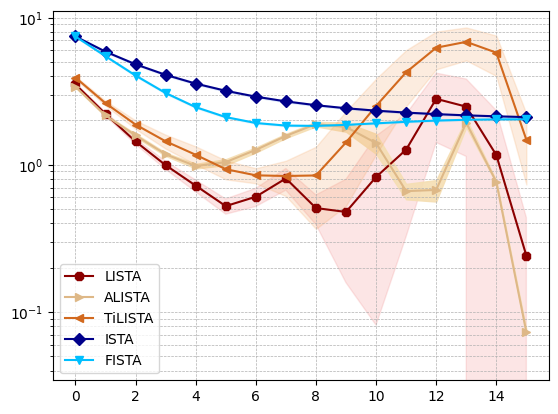

In [49]:
plt.plot(np.mean(LISTA_LOSS, axis = 0), label='LISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(LISTA_LOSS, axis = 0) - (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    np.mean(LISTA_LOSS, axis = 0) + (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    color='lightcoral', 
                    alpha=0.2)

plt.plot(np.mean(ALISTA_LOSS, axis = 0), label='ALISTA', color='burlywood', marker = '>')
plt.fill_between(range(LAYERS), 
                    np.mean(ALISTA_LOSS, axis = 0) - (2/np.sqrt(ALISTA_LOSS.shape[1])) * np.std(ALISTA_LOSS, axis = 0), 
                    np.mean(ALISTA_LOSS, axis = 0) + (2/np.sqrt(ALISTA_LOSS.shape[1])) * np.std(ALISTA_LOSS, axis = 0), 
                    color='wheat', 
                    alpha=0.9)

plt.plot(np.mean(TiLISTA_LOSS, axis = 0), label='TiLISTA', color='chocolate', marker = '<')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLISTA_LOSS, axis = 0) - (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    np.mean(TiLISTA_LOSS, axis = 0) + (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    color='sandybrown', 
                    alpha=0.2)

plt.plot(np.mean(L2O_ISTA_LOSS, axis = 0), label='L2O-ISTA', color='tan', marker = '^')
plt.fill_between(range(LAYERS), 
                    np.mean(L2O_ISTA_LOSS, axis = 0) - (2/np.sqrt(L2O_ISTA_LOSS.shape[1])) * np.std(L2O_ISTA_LOSS, axis = 0), 
                    np.mean(L2O_ISTA_LOSS, axis = 0) + (2/np.sqrt(L2O_ISTA_LOSS.shape[1])) * np.std(L2O_ISTA_LOSS, axis = 0), 
                    color='moccasin', 
                    alpha=0.2)

plt.plot(np.mean(ISTA_LOSS, axis = 0), label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0) - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                np.mean(ISTA_LOSS, axis = 0) + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                color='cornflowerblue', 
                alpha=0.2)

plt.plot(np.mean(FISTA_LOSS, axis = 0), label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(LAYERS), 
                np.mean(FISTA_LOSS, axis = 0) - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                np.mean(FISTA_LOSS, axis = 0) + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                color='skyblue', 
                alpha=0.2)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.legend()
plt.yscale('log')